# Optimal resource allocation in microbial growth
Sacha PSALMON, Baptiste SCHALL, Enzo ISNARD and Guillaume GROS

[![app](http://static.mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.inria.fr%2Fct%2Fgallery.git/master?urlpath=%2Fproxy%2F5006%2Fbacteria-panel)

<img src="bacteria-panel.jpeg" width=400>

[Thumbnail](bacteria-panel.jpeg)

Microorganisms must assign the resources available in the environment to different cellular functions. In nature, it is assumed that bacteria have evolved in a way that their resource allocation strategies maximize their biomass. Consider the simple resource allocation mathematical model

$$ \begin{array}{rcl}
\dot{p} &=& E_m m - (p+1) v_R(p,r), \\
\dot{r} &=& (\alpha r_{max}-r) v_R(p,r), \\
\dot{m} &=& ((1-\alpha) r_{max}-m) v_R(p,r),
\end{array} $$

where $p$, $r$, $m$ and $q$ are the mass fractions of: precursor metabolites, the gene expression machinery (ribosomes, RNA polymerase...), the metabolic machinery (enzymes, transporters...) and the housekeeping machinery respectively. The microbial growth rate is defined as $v_R(p,r) = \frac{p(r-r_{min})}{K+p}$. Constants $E_M$, $r_{max}$, $r_{min}$ and $K$ are positive. Maximizing the bacterial biomass is equivalent to maximizing the integral of the growth rate over a fixed time window $[0,T]$. Thus, the cost function of the optimal control problem can be written as

$$J(\alpha) = \int_0^T v_R(p,r) \, \mathrm{d}t \to \max $$

with the resource allocation parameter (i.e. the control) constrained to $\alpha(t) \in [0,1]$.

# Panel app

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

import numpy as np
import math
import os,shutil

os.system("pygmentize ./problem.cpp")

import bocop

plt.ioff()

In [2]:
import panel as pn
import param
pn.extension()
pn.config.sizing_mode = 'stretch_width'

os.environ["LC_ALL"]="C" # format pb with ipopt otherwise (Nan values!)
os.environ["LANG"]="C"

In [3]:
class bacteria():
     
    def __init__(self, file, naive_file="naiveproblem.def", working_file="problem.def", path_def="def", problem1_path="."):
        
        # Init paths
        self.path_def       = path_def
        self.problem1_path  = problem1_path
        
        self.file           = os.path.join(problem1_path, file)
        self.naive_file     = os.path.join(problem1_path, naive_file)
        self.working_file   = os.path.join(problem1_path, working_file)
        
        self.sol_name       = self.file.replace('.def','.sol')
        self.sol_naive_name = self.naive_file .replace('.def','.sol')
        
        
        # Init attrs
        self.figure     = plt.figure()
        self.time_steps = 0
        self.is_built   = False
        
        # Create copy
        shutil.copyfile(os.path.join(path_def, file),       self.file)
        shutil.copyfile(os.path.join(path_def, naive_file), self.naive_file)
        
        # Get params from .def
        self.options    = {}
        self.param_list = {}
        self.name_list  = {"boundarycond.0" : "p0",
                           "boundarycond.1" : "r0",
                           "boundarycond.2" : "m0",
                           "boundarycond.3" : "V0",
                           "constant.0"     : "Em",
                           "constant.1"     : "K",
                           "constant.2"     : "rmax",
                           "constant.3"     : "rmin"}
        
        self.lowerbound_list = {}
        self.upperbound_list = {}
        self.initParamlist()
        
        # Create run button
        self.run_button = pn.widgets.Button(name='Run simulation', button_type="success")
        self.run_button.on_click(self.run)
        
        # Create progress bar
        self.progress_bar = pn.widgets.Progress(sizing_mode='stretch_width')
        self.progress_bar.visible = False
        
        # Create param tabs
        self.param_tabs = pn.Column()
        self.initParamsTab()
        
        # Create dashboard 
        self.dashboard = pn.template.BootstrapTemplate(title='Optimal resource allocation in microbial growth')
        self.initDashboard()
        
    def initParamlist(self):
        
        self.lowerbound_list = {}
        self.upperbound_list = {}
        self.param_list      = {}
        self.options = bocop.readDefFile(deffile=self.file)
        self.final_time = 0

        for key, value in self.options.items():
            if "boundarycond" in key  and ("upperbound" in key or "lowerbound" in key) :
                idx = key.split(".")[1]
                self.param_list[idx] = value
            elif "state" in key and "lowerbound" in key :
                idx = key.split(".")[1]
                self.lowerbound_list[idx]= value
            elif "state" in key and "upperbound" in key :
                idx = key.split(".")[1]
                self.upperbound_list[idx]= value
            elif "constant" in key and "dim" not in key :
                self.param_list[key]=value
            elif "final.time" in key :
                self.param_list[key] = value
            elif "time.steps" in key :
                self.time_steps = value
        for key, value in self.options.items():        
            if "constant" in key and (key.split(".")[1] == "2") : 
                self.upperbound_list["1"]= value
            elif "constant" in key and (key.split(".")[1] == "3") : 
                self.lowerbound_list["1"]= value
            
            
            
        
    def initParamsTab(self):
    
        # Create panel tabs
        tabs          = pn.Tabs() 
        col_states    = pn.Column()
        col_constants = pn.Column()

        # Create widgets for params
        for key, value in self.param_list.items():
            name = key
            if name in self.name_list:
                name = self.name_list[name]                      
            name_key   = "boundarycond.{idx}".format(idx=key)
            if name_key in self.name_list:
                name = self.name_list[name_key]
            
            if key in "final.time" :
                param_widget = pn.widgets.IntInput(name=name, value=int(value))
            else :
                param_widget = pn.widgets.FloatInput(name=name, value=float(value))    
            
            if key.isnumeric():
                if key in self.lowerbound_list :
                       param_widget.start = float(self.lowerbound_list[key])   
                if key in self.upperbound_list :
                       param_widget.end   = float(self.upperbound_list[key])

                param_bind_lower = pn.bind(bocop.setInDef, key="boundarycond.{idx}.upperbound".format(idx=key),
                                           value=param_widget, deffile=self.file)
                param_naive_bind_lower = pn.bind(bocop.setInDef, key="boundarycond.{idx}.upperbound".format(idx=key),
                                           value=param_widget, deffile=self.naive_file)
                param_bind_upper = pn.bind(bocop.setInDef, key="boundarycond.{idx}.lowerbound".format(idx=key),
                                           value=param_widget, deffile=self.file)
                param_naive_bind_upper = pn.bind(bocop.setInDef, key="boundarycond.{idx}.lowerbound".format(idx=key),
                                           value=param_widget, deffile=self.naive_file)

                pn.Row(param_bind_lower, param_naive_bind_lower, param_bind_upper, param_naive_bind_upper, param_widget)
                col_states.append(param_widget)
                
            else:
                param_bind = pn.bind(bocop.setInDef, key=key,
                                           value=param_widget, deffile=self.file)
                param_naive_bind = pn.bind(bocop.setInDef, key=key,
                                           value=param_widget, deffile=self.naive_file)
                pn.Row(param_bind, param_naive_bind, param_widget)
                col_constants.append(param_widget)


        tabs.extend([('States', col_states),
                     ('Constants', col_constants),
                    ])
        text = 'Simulation performed by <a href="https://ct.gitlabpages.inria.fr/bocop3">bocop</a>. \
        See <a href="https://ct.gitlabpages.inria.fr/gallery">ct (control toolbox)</a> project.'
        self.param_tabs = pn.Column(pn.widgets.StaticText(value=text), tabs)
        
    def initDashboard(self):
        text = 'Microorganisms must assign the resources available in the environment to different cellular \
        functions. In nature, it is assumed that bacteria have evolved in a way that their resource \
        allocation strategies maximize their biomass. Consider a simple resource allocation \
        mathematical model where p, r, m and q are the mass fractions of precursor metabolites, \
        the gene expression machinery (ribosomes, RNA polymerase...), \
        the metabolic machinery (enzymes, transporters...) and the housekeeping machinery respectively. \
        Maximizing the bacterial biomass is equivalent to maximizing the integral of the growth rate \
        over a fixed time window wrt. to the resource allocation parameter (i.e. the control) α. \
        For more details, see this <a href="https://ct.gitlabpages.inria.fr/gallery/bacteria/bacteria.html">notebook</a>.'
        self.dashboard = pn.template.BootstrapTemplate(title='Optimal resource allocation in microbial growth')
        self.dashboard.sidebar.append(self.sideBar())
        self.dashboard.main.append(pn.Row(pn.Column(pn.pane.PNG("maintenance.png", width=300)),\
                                          pn.Column(pn.widgets.StaticText(value=text))))
        self.dashboard.main.append(pn.Row(plt.figure()))
        self.dashboard.servable();
        
    def paramTabs(self):
        return self.param_tabs
  
    def runButton(self):
        return self.run_button
    
    def progressBar(self):
        return self.progress_bar
    
    def mainView(self):
        return self.dashboard
    
    def sideBar(self):
        return pn.Column('##Parameters', pn.Row(pn.Column(self.paramTabs(),                                                   
                                                          pn.Column(
                                                              self.runButton(),
                                                              self.progressBar())
                                                          )))
    def show(self):
        self.dashboard.show()
    
    def plotView(self):
        return self.dashboard.main[0]
    
    # Plots
    def updatePlot(self):
        if not os.path.exists(self.sol_name) or not os.path.exists(self.sol_naive_name) :
            return plt.figure()
        
        solution = bocop.readSolution(self.sol_name)
        naivesol = bocop.readSolution(self.sol_naive_name)
        
        length=len(solution.state[1])
             
        langs=['r','m','q']
        colors = ["#374e55","#b24746", "#79af97"]

        fig = plt.figure(figsize=(14,10))
        ax1 = plt.subplot(3,2,1)
        ax2 = plt.subplot(3,2,2)

        rmin = 0.07
        rmax = 0.5
        umin = rmin/rmax
        Em = 0.7; K = 0.003
        param = [Em,K,rmax,rmin]

        popt = np.sqrt(K*Em)
        f = popt/(K + popt)*(popt+1)
        uopt = (Em + f*rmin/rmax)/(Em + f)
        ropt = uopt*rmax
        mopt = (1-uopt)*rmax
        muopt = popt/(K + popt)*(ropt-rmin)

        t = solution.time_steps
        p = solution.state[0]
        r = solution.state[1]
        m = solution.state[2]
        V = solution.state[3]
        u = solution.control[0]
        q = 1 - r - m
        mu = p*(r-rmin)/(K + p)

        t0 = t[0]; t1 = t[-1]
        
        slider = pn.widgets.FloatSlider(name='Time', step = t1/len(t), start=0, end=t1)
        
        ax = plt.subplot(3,2,3);
        plt.xlabel('t')
        plt.ylabel('Allocation $\\alpha$')
        ax.plot([t0,t1],[0,0],linewidth=1,color='grey',linestyle='--')
        ax.plot([t0,t1],[1,1],linewidth=1,color='grey',linestyle='--')
        ax.plot([t0,t1],[uopt,uopt],linewidth=1, linestyle='dotted', color='black',label='$\\alpha^*_{opt}$')
        ax.plot(t[1:],u,linewidth=1,label='$\\alpha$')
        ax.plot(t[1:], u)

        ax3 = plt.subplot(3,2,4);
        ax3.plot([t0,t1],[popt,popt],linewidth=1, linestyle='dotted', color='black',label='$\hat p^*_{opt}$')
        ax3.plot(t, p, linewidth=1, label='$p$')
        ax3.set_xlim(t0,t1)

        ax4 = plt.subplot(3,2,5);
        ax4.plot([t0,t1],[rmin,rmin],linewidth=1,color='grey',linestyle='--')
        ax4.plot([t0,t1],[rmax,rmax],linewidth=1,color='grey',linestyle='--')
        ax4.plot([t0,t1],[ropt,ropt],linewidth=1, linestyle='dotted', color='black',label='$\hat r^*_{opt}$')
        ax4.plot(t, r, linewidth=1, label='$p$')
        ax4.set_xlim(t0,t1)

        ax5 = plt.subplot(3,2,6);
        ax5.plot([t0,t1],[muopt,muopt],linewidth=1, linestyle='dotted', color='black',label='$\\mu^*_{opt}$')
        ax5.plot(t, mu, linewidth=1, label='$p$')
        ax5.set_xlim(t0,t1)

        def update(frame):
            ax1.clear()
            ax2.clear()
            dt=t1/len(t)
            frame = int(frame/dt) 
            r=solution.state[1][frame]
            m=solution.state[2][frame]
            q=1-r-m
            rn=naivesol.state[1][frame]
            mn=naivesol.state[2][frame]
            qn=1-rn-mn

            ax1.pie([r,m,q], colors=colors, labels=langs, autopct='%1.2f%%',startangle=90,radius=math.sqrt(solution.state[3][frame])*3+0.7)
            title1='Volume (optimal control) = '+str(round(solution.state[3][frame],5))
            ax1.set_title(title1)

            ax2.pie([rn,mn,qn], colors=colors, labels=langs, autopct='%1.2f%%',startangle=90,radius=math.sqrt(naivesol.state[3][frame])*3+0.7)
            title2='Volume (naive method) = '+str(round(naivesol.state[3][frame],5))
            ax2.set_title(title2)
            return fig
        
        def alpha(x):
            ax.clear()
            ax.grid(linestyle='dotted')
            ax.set_title('Allocation $\\alpha$')
            dt=t1/len(t)
            x = int(x/dt)
            ax.plot([t0,t1],[0,0],linewidth=1,color='grey',linestyle='--')
            ax.plot([t0,t1],[1,1],linewidth=1,color='grey',linestyle='--')
            ax.plot([t0,t1],[uopt,uopt],linewidth=1, linestyle='dotted', color='black',label='$\\alpha^*_{opt}$')
            ax.plot(t[1:],u,linewidth=1,label='$\\alpha$')
            ax.plot(t[x],u[x],'ro')
            return fig

        def p_function(x):
            ax3.clear()
            ax3.grid(linestyle='dotted')
            ax3.set_title("$p$")
            dt=t1/len(t)
            x = int(x/dt)
            ax3.plot([t0,t1],[popt,popt],linewidth=1, linestyle='dotted', color='black',label='$\hat p^*_{opt}$')
            ax3.plot(t, p, linewidth=1, label='$p$')
            ax3.plot(t[x],p[x],'ro')
            return fig

        def r_function(x):
            ax4.clear()
            ax4.grid(linestyle='dotted')
            ax4.set_title("$r$")
            dt=t1/len(t)
            x = int(x/dt)
            ax4.plot([t0,t1],[rmin,rmin],linewidth=1,color='grey',linestyle='--')
            ax4.plot([t0,t1],[rmax,rmax],linewidth=1,color='grey',linestyle='--')
            ax4.plot([t0,t1],[ropt,ropt],linewidth=1, linestyle='dotted', color='black',label='$\hat r^*_{opt}$')
            ax4.plot(t, r, linewidth=1, label='$p$')
            ax4.plot(t[x],r[x],'ro')
            return fig

        def mu_function(x):
            ax5.clear()
            ax5.grid(linestyle='dotted')
            ax5.set_title("Growth rate $\\mu$")
            dt=t1/len(t)
            x = int(x/dt)
            ax5.plot([t0,t1],[muopt,muopt],linewidth=1, linestyle='dotted', color='black',label='$\\mu^*_{opt}$')
            ax5.plot(t, r, linewidth=1, label='$p$')
            ax5.plot(t[x],r[x],'ro')
            return fig

        pn.interact(update,frame=slider)
        pn.interact(alpha,x=slider)
        pn.interact(p_function,x=slider)
        pn.interact(r_function,x=slider)
        self.figure = pn.interact(mu_function,x=slider)
    
    # Callback
    def run(self, event):
        self.run_button.button_type = "warning"
        self.progress_bar.visible = True
        if not self.is_built:
            self.run_button.name = "Building..."
            bocop.build(self.problem1_path, cmake_options = '-DCMAKE_CXX_COMPILER=g++');
            self.is_built = True
            
        self.run_button.name = "Running..."
        for f in [self.file, self.naive_file]:
            os.rename(f, self.working_file)
            bocop.run(self.problem1_path, graph=0)
            os.rename(self.working_file.replace('.def','.sol'), f.replace('.def','.sol'))
            os.rename(self.working_file, f)
        
        self.updatePlot()
        self.dashboard.main[1][0] = self.figure # main[1] is the second row of main, etc.
        self.progress_bar.visible = False
        self.run_button.name = "Run simulation"  
        self.run_button.button_type = "success"

In [4]:
prob_1 = bacteria('problem1.def', path_def="def", problem1_path=".")
prob_1.sideBar()

Column(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row(sizing_mode='stretch_width')
        [0] Column(sizing_mode='stretch_width')
            [0] Column(sizing_mode='stretch_width')
                [0] StaticText(sizing_mode='stretch_width', value='Simulation performed b...)
                [1] Tabs(sizing_mode='stretch_width')
                    [0] Column(sizing_mode='stretch_width')
                        [0] FloatInput(name='p0', sizing_mode='stretch_width', start=0.0, value=0.03)
                        [1] FloatInput(end=0.5, name='r0', sizing_mode='stretch_width', start=0.07, value=0.1)
                        [2] FloatInput(name='m0', sizing_mode='stretch_width', start=0.0, value=0.2)
                        [3] FloatInput(name='V0', sizing_mode='stretch_width', start=0.0, value=0.003)
                    [1] Column(sizing_mode='stretch_width')
                        [0] IntInput(name='final.time', sizing_mode='stretch_width', value=20)
                        [1] FloatInput(name='Em', sizing_mode='stretch_width', value=0.6)
                        [2] FloatInput(name='K', sizing_mode='stretch_width', value=0.003)
                        [3] FloatInput(name='rmax', sizing_mode='stretch_width', value=0.5)
                        [4] FloatInput(name='rmin', sizing_mode='stretch_width', value=0.07)
            [1] Column(sizing_mode='stretch_width')
                [0] Button(button_type='success', name='Run simulation', sizing_mode='stretch_width')
                [1] Progress(sizing_mode='stretch_width', visible=False)

Row(sizing_mode='stretch_width')
    [0] Column(sizing_mode='stretch_width')
        [0] PNG(str, sizing_mode='stretch_width', width=300)
    [1] Column(sizing_mode='stretch_width')
        [0] StaticText(sizing_mode='stretch_width', value='Microorganisms must assig...)
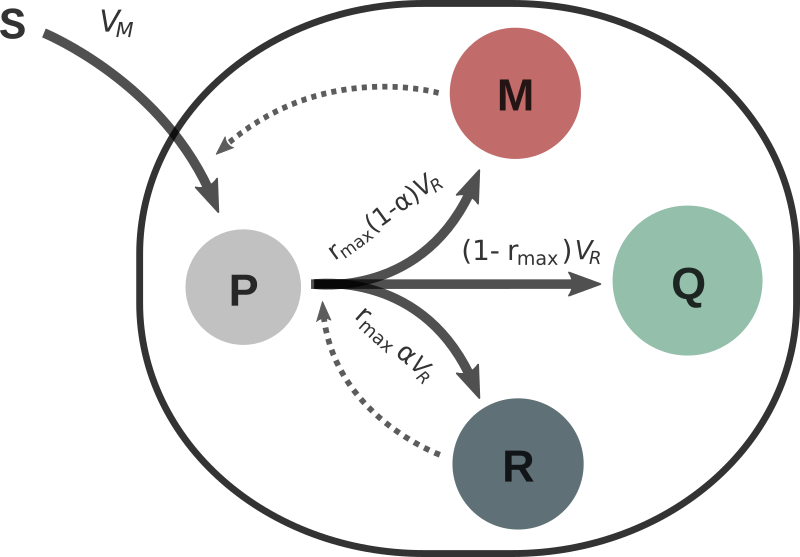

In [5]:
plots = prob_1.plotView();
plots

In [6]:
prob_1.show()

#if (not os.environ["_"].endswith("bokeh")): # Checks this code is not trying to execute inside of bokeh
#    !bokeh serve --show bacteria-panel.ipynb --log-level debug

Launching server at http://localhost:33765
